# Computing Laplacian Transforms with Hankel vs FFT

This will compare the forward and inverse transforms for both Hankel and Fourier by either computing partial derivatives of solving a parital differential equation. This notebook focuses on the Laplacian operator in the case of radial symmetry. 

Consider two 2D circularly-symmetric functions $f(r)$ and $g(r)$ that are related by the following differential operator,

$$
g(r) = \nabla^2 f(r) 
= \frac{1}{r} \frac{\partial}{\partial r} \left( r \frac{\partial f}{\partial r} \right)
$$

In this notebook we will consider four problems:
1. Given $f(r)$, compute the Laplacian to obtain $g(r)$
2. Given $g(r)$, invert the Laplacian to obtain $f(r)$
3. Repeat step 1., but under the assumption that $f(r)$ is defined in 3D.
4. Repeat step 1., but for $n$-dimensional $f(r)$.

For our fiducial 2D case, we can use the 1D Hankel (or 2D Fourier) transform to compute the Laplacian in three steps:

1. Compute the Forward Transform
    
$$
    \mathcal{H}[f(r)] = \hat f(k)
$$

2. Differentiate in Spectral space

$$
    \hat g(k) = - k^2 \hat f(k)
$$$

3. Compute the Inverse Transform

$$
    g(r) = \mathcal{H}^{-1} [\hat g(k)]
$$

In particular, we will use the function

$$
f(r) = e^{-r^2},
$$

and, though it is arbitrary, we will use the Fourier convention that $(a, b)=(1,1)$ (i.e. $F(k) = \int dr\  f(r) e^{-ik\cdot r}$). This gives the corollary functions

$$
    \hat{f}(k) = \pi e^{-k^2/4}
$$

$$
    \hat{g}(k) = -k^2 \pi e^{-k^2/4}
$$

$$
    g(r) = 4 e^{-r^2} (r^2 - 1)
$$

This is easily done in two-dimensions using the Fast Fourier Transform (FFT) but one advantage of the Hankel transform is that we only have a one-dimensional transform. The purpose of this notebook is twofold:

1. To show how one would solve the $n$-dimensional Laplacian numerically using Hankel transforms
2. To compare the performance and accuracy of the Hankel-based approach and an FFT-based approach to the solutions.

We shall see that over a suitable range of scales, and for low number of dimensions $n$, the FFT approach is more accurate than the Hankel approach, due to the fact that its forward-then-inverse operation is an identity operation by construction (whereas the numerical Hankel routine loses information in both directions). Nevertheless, the Hankel method, without much tuning, is shown to be accurate to $10^{-5}$ over many of the useful scales. Furthermore, as the dimensionality grows, the Hankel transform becomes the only viable option computationally.

## Setup

### Import Relevant Libraries

In [3]:
# Import Libraries

import numpy as np                                                        # Numpy
from powerbox import dft                                                  # powerbox for DFTs (v0.6.0+)
from hankel import SymmetricFourierTransform                              # Hankel
from scipy.interpolate import InterpolatedUnivariateSpline as spline      # Splines
import matplotlib.pyplot as plt                                           # Plotting
%matplotlib inline

import hankel
print("Using hankel v{}".format(hankel.__version__))

Using hankel v0.3.8


### Define Sample Functions

In [4]:
f = lambda r: np.exp(-r**2)
g = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.0)
fhat = lambda k : np.pi * np.exp(-k**2/4)
ghat = lambda k : -k**2 * np.pi * np.exp(-k**2/4)

### Define Transformation Functions

In [15]:
def ft2d(X, L, inverse=False):
    """Convenience function for getting nD Fourier Transform and a 1D function of it"""
    if inverse:
        ft, _, xgrid = dft.ifft(X, L=L, a=1, b=1, ret_cubegrid=True)
    else:
        ft, _, xgrid = dft.fft(X, L=L, a=1, b=1, ret_cubegrid=True)
            
    # Get a sorted array of the transform
    ind = np.argsort(xgrid.flatten())
    _xgrid = xgrid.flatten()[ind]
    _ft = ft.flatten()[ind]
    
    # Just take unique values.
    _xgrid, ind = np.unique(_xgrid, return_index=True)
    _ft = _ft[ind]
    
    return ft, xgrid, _xgrid, _ft.real # we only deal with real functions here.

### Grid Setup

In [4]:
L     = 10.0    # Size of box for transform
N     = 128     # Grid size
b0    = 1.0

In [77]:
# Create the Hankel Transform object

ht = SymmetricFourierTransform(ndim=2, h=0.005)

In [20]:
dr = L/N

# Create persistent dictionaries to track Hankel and Fourier results throughout.
H = {} # Hankel dict
F = {} # Fourier dict

r = np.linspace(dr/2, L-dr/2, N)

# 1D Grid for Hankel
H['r'] = r

# To decide on k values to use, we need to know the scales
# we'll require to evaluate on the *inverse* transform:
H['k'] = np.logspace(-0.5, 2.1, 2*N)      # k-space is rather arbitrary.

# 2D Grid for Fourier
F['x'] = np.arange(-N, N)*dr
F['rgrid'] = np.sqrt(np.add.outer(F['x']**2, F['x']**2))
F['fgrid'] = f(F['rgrid'])

### Analytic Result

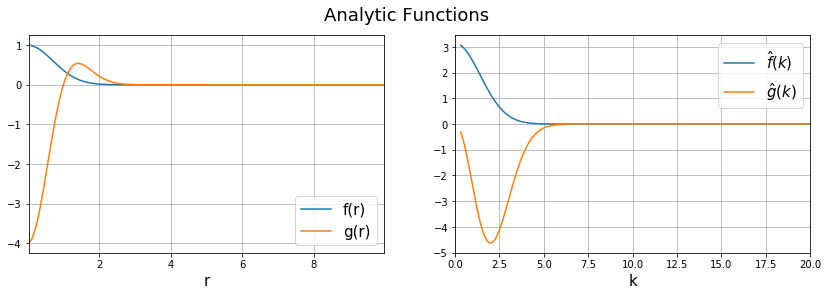

In [21]:
fig, ax = plt.subplots(1,2, gridspec_kw={"hspace":0.05}, figsize=(14, 4))

ax[0].plot(r, f(r), label="f(r)")
ax[0].plot(r, g(r), label='g(r)')
ax[0].set_xlim(r.min(), r.max())
plt.suptitle('Analytic Functions', fontsize=18)
ax[0].legend(loc='best', fontsize=15);
ax[0].set_xlabel("r", fontsize=15)

ax[1].plot(H['k'], fhat(H['k']), label="$\hat{f}(k)$")
ax[1].plot(H['k'], ghat(H['k']), label="$\hat{g}(k)$")
ax[1].legend(loc='best', fontsize=15)
ax[1].set_xlabel('k', fontsize=15)
ax[1].set_xlim(0, 20)

ax[0].grid(True)
ax[1].grid(True)

### Utility Functions

In [22]:
def plot_comparison(x, y, ylabel, comp_ylim=None, F=F, H=H, **subplot_kw):
    fnc = globals()[y]
    
    subplot_kw.update({"xscale":'log'})
    
    fig, ax = plt.subplots(
        2,1, sharex=True, subplot_kw=subplot_kw, 
        figsize=(12, 7), gridspec_kw={"hspace":0.07})

    ax[0].plot(H[x], fnc(H[x]), linewidth=2, label="Analytic", color="C2")
    ax[0].plot(H[x], H[y],linewidth=2, ls="--", label="Hankel")
    ax[0].plot(F[x], F[y],linewidth=2, ls="--", label="Fourier")
    
    ax[0].legend(fontsize=14)
    ax[0].grid(True)
    ax[0].set_ylabel(ylabel, fontsize=15)

    ax[1].plot(H[x], np.abs(H[y] - fnc(H[x])))
    ax[1].plot(F[x], np.abs(F[y] - fnc(F[x])))
    ax[1].grid(True)
    ax[1].set_ylabel("Residual", fontsize=15)
    ax[1].set_xlabel(x, fontsize=15)
    ax[1].set_yscale('log')
        
    if comp_ylim:
        ax[1].set_ylim(comp_ylim)

## Example 1: Compute Laplacian

### 1. Forward Transform

#### a. Hankel

In [195]:
# Compute Hankel transform

H['fhat'] = ht.transform(f, H['k'], ret_err=False)        # Return the transform of f at k.

#### b. Fourier

In [196]:
F['fhat_grid'], F['kgrid'], F['k'], F['fhat'] = ft2d(F['fgrid'], 2*L)

#### c. Comparison

Comparing the results of the Hankel and Fourier Transforms, we have

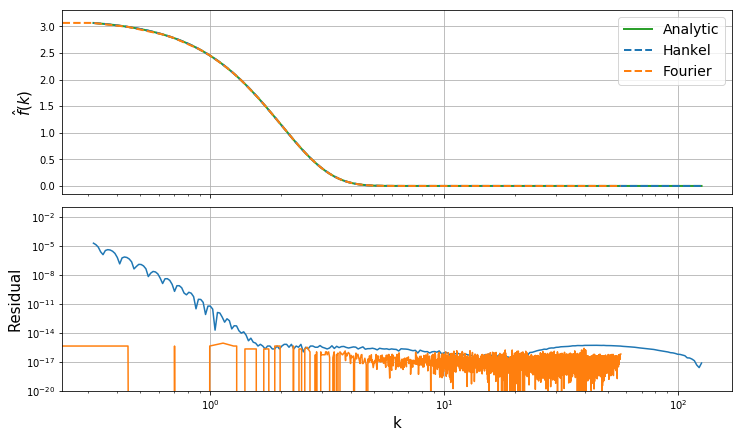

In [197]:
plot_comparison('k', 'fhat', "$\hat{f}(k)$", comp_ylim=(1e-20, 1e-1))

### 2. Inverse Transform

#### a. Hankel

In [198]:
# Build a spline to approximate ghat

H['ghat'] =  -H['k']**2 * H['fhat']

# We can build the spline carefully since we know something about the function
spl = spline(np.log(H['k'][H['ghat']!=0]), np.log(np.abs(H['ghat'][H['ghat']!=0])), k=2)
_fnc = lambda k: np.where(k < 1e2, -np.exp(spl(np.log(k))), 0)

# Do the transform
H['g'] = ht.transform(_fnc, H['r'], ret_err=False, inverse=True)

#### b. Fourier

In [199]:
F['ghat'] =  -F['kgrid']**2 *F['fhat_grid']
F['ggrid'], _, F['r'], F['g'] = ft2d(F['ghat'], 2*L, inverse=True)

#### c. Compare

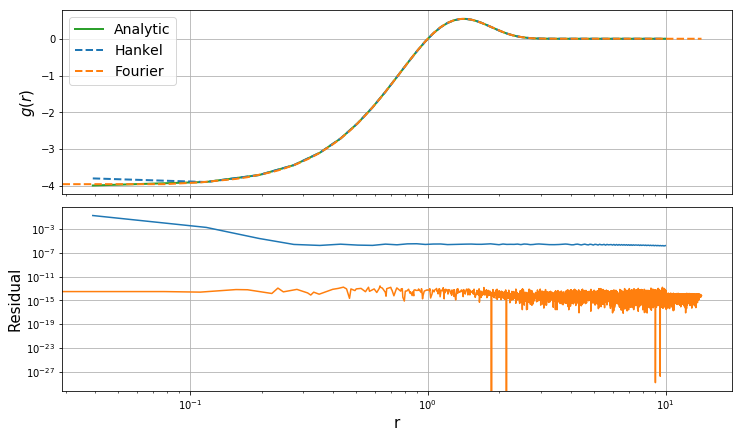

In [200]:
plot_comparison('r', 'g', "$g(r)$")

## Example 2: Invert Laplacian

The Laplacian transformation can be inverted by following a similar set of steps in reverse:

1. Compute the Forward Transform

    $$
    \mathcal{H}[g(r)] = \hat g(k)
    $$

2. Differentiate in Spectral space

    $$
    \hat f(k) = - \frac{1}{k^2} \hat g(k)
    $$

3. Compute the Inverse Transform

    $$
    f(r) = \mathcal{H}^{-1} [\hat f(k)]
    $$

### 1. Forward Transform

#### a. Hankel

In [201]:
H['ghat'] = ht.transform(g, H['k'], ret_err=False)        # Return the transform of g at k.

#### b. Fourier

In [202]:
# Compute Fourier Transform

F['ghat_grid'], _, _, F['ghat'] = ft2d(g(F['rgrid']), 2*L)

#### c. Compare

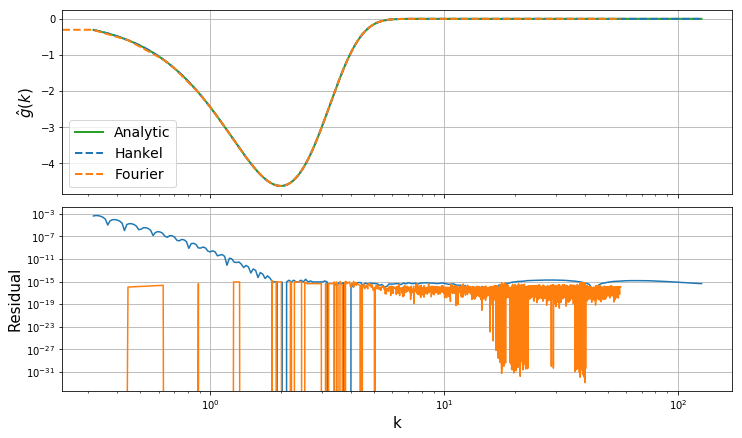

In [203]:
plot_comparison('k', 'ghat', "$\hat{g}(k)$")

### 2. Inverse Transform

#### a. Hankel

In [204]:
# Interpolate onto a spline

spl_inv = spline(H['k'], -H['ghat']/H['k']**2)
H['f'] = ht.transform(spl_inv, H['r'], ret_err=False, inverse=True)

#### b. Fourier

In [205]:
# Differentiate in spectral space

F['fhat'] =  -F['ghat_grid']/ F['kgrid']**2
F['fhat'][np.isnan(F['fhat'])] = np.pi # This is the limiting value at k=0.

F['fgrid'], _, F['r'], F['f'] = ft2d(F['fhat'], 2*L, inverse=True)

/home/steven/miniconda3/envs/hankel/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in true_divide
  app.launch_new_instance()
/home/steven/miniconda3/envs/hankel/lib/python3.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


#### c. Compare

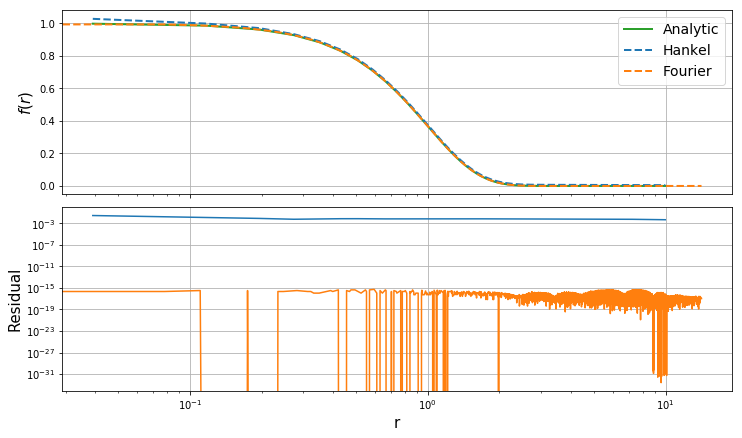

In [206]:
plot_comparison('r', 'f', "$f(r)$")

## Example 3: Laplacian in 3D

Generalising  the previous calculations slightly, we can perform the Laplacian transformation in 3D using the Hankel transform correspondin to a circularly-symmetric FT in 3-dimensions (see the "Getting Started" notebook for details). Analytically, we obtain

$$
    \hat{f}(k) = \pi^{3/2} e^{-k^2/4} \\
    \hat{g}(k) = -k^2 \pi^{3/2} e^{-k^2/4} \\ 
    g(r) = 4e^{-r^2} (r^2 - 1.5) \\
$$

### Analytic Functions

In [6]:
g3 = lambda r: 4.0*np.exp(-r**2)*(r**2 - 1.5)
fhat3 = lambda k : np.pi**(3./2) * np.exp(-k**2/4)
ghat3 = lambda k : -k**2 * fhat3(k)

### Grid Setup

In [2]:
L     = 10.0    # Size of box for transform
N     = 128     # Grid size
b0    = 1.0

In [7]:
# Create the Hankel Transform object

ht = SymmetricFourierTransform(ndim=3, h=0.005)

In [11]:
dr = L/N

# Create persistent dictionaries to track Hankel and Fourier results throughout.
H3 = {} # Hankel dict
F3 = {} # Fourier dict

r = np.linspace(dr/2, L-dr/2, N)

# 1D Grid for Hankel
H3['r'] = r

# To decide on k values to use, we need to know the scales
# we'll require to evaluate on the *inverse* transform:
H3['k'] = np.logspace(-0.5, 2.1, 2*N)      # k-space is rather arbitrary.

# 2D Grid for Fourier
F3['x'] = np.arange(-N, N)*dr
F3['rgrid'] = np.sqrt(np.add.outer(F3['x']**2, np.add.outer(F3['x']**2, F3['x']**2))).reshape((len(F3['x']),)*3)
F3['fgrid'] = f(F3['rgrid'])

### Forward

In [24]:
H3['fhat3'] = ht.transform(f, H3['k'], ret_err=False)
F3['fhat_grid'], F3['kgrid'], F3['k'], F3['fhat3'] = ft2d(F3['fgrid'], 2*L)

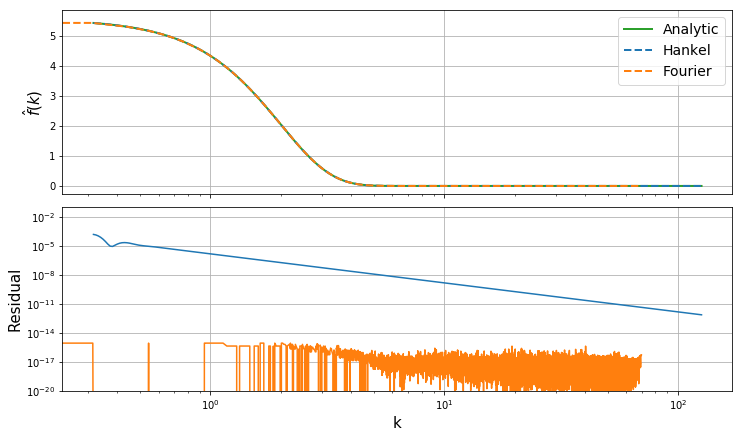

In [25]:
plot_comparison('k', 'fhat3', "$\hat{f}(k)$", comp_ylim=(1e-20, 1e-1), F=F3, H=H3)

### Backward

In [28]:
# Build a spline to approximate ghat

H3['ghat3'] =  -H3['k']**2 * H3['fhat3']

# We can build the spline carefully since we know something about the function
spl = spline(np.log(H3['k'][H3['ghat3']!=0]), np.log(np.abs(H3['ghat3'][H3['ghat3']!=0])), k=2)
_fnc = lambda k: np.where(k < 1e2, -np.exp(spl(np.log(k))), 0)

# Do the transform
H3['g3'] = ht.transform(_fnc, H3['r'], ret_err=False, inverse=True)

In [34]:
F3['ghat3'] =  -F3['kgrid']**2 *F3['fhat_grid']
F3['ggrid'], _, F3['r'], F3['g3'] = ft2d(F3['ghat3'], 2*L, inverse=True)

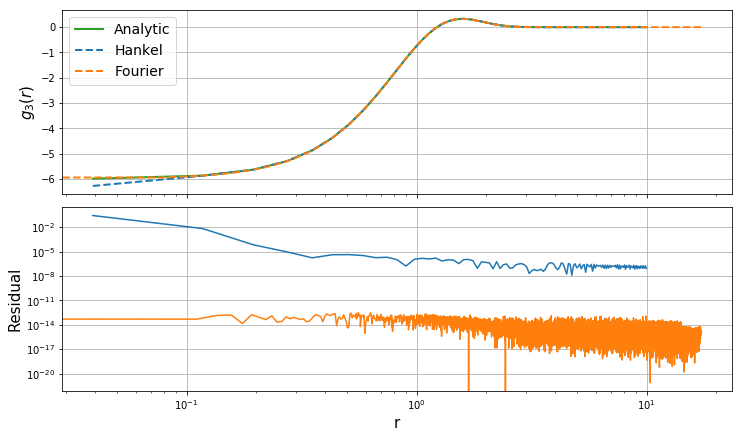

In [35]:
plot_comparison('r', 'g3', "$g_3(r)$", H=H3, F=F3)

## n-Dimensional Transform

Generalising again, the $n$-dimensionsal transform functions can be written

$$
    \hat{f}(k) = \pi^{n/2} e^{-k^2/4} \\
    \hat{g}(k) = -k^2 \pi^{n/2} e^{-k^2/4} \\ 
    g(r) = 2 e^{-r^2} (2 r^2 - n) \\
$$

In this section, we show the performance (both in speed and accuracy) of the Hankel transform algorithm to produce $g(r)$ for arbitrary dimensions. We do not use the FT-method in this section as its memory consumption obviously scales as $N^n$, and its CPU performance as $n N^n \log N$.

In [40]:
gn = lambda r, n: 2* np.exp(-r**2) * (2*r**2 - n)

In [37]:
def gn_hankel(r, n, h=0.005):
    ht = SymmetricFourierTransform(ndim=n, h=h)
    k = np.logspace(-0.5, 2.1, 2*N)   
    
    fhat = ht.transform(f, k, ret_err=False)
    
    ghat =  -k**2 * fhat

    # We can build the spline carefully since we know something about the function
    spl = spline(np.log(k[ghat!=0]), np.log(np.abs(ghat[ghat!=0])), k=2)
    _fnc = lambda k: np.where(k < 1e2, -np.exp(spl(np.log(k))), 0)

    # Do the transform
    return ht.transform(_fnc, r, ret_err=False, inverse=True)

In [49]:
rs = np.array([0.5, 1.1, 1.5])
ns = np.arange(2, 12)

In [50]:
transform_at_r1 = np.array([gn_hankel(rs, n) for n in ns])   # Get numerical answers

In [56]:
transform_at_r1_anl = np.array([gn(rs, n) for n in ns])      # Get analytic answers

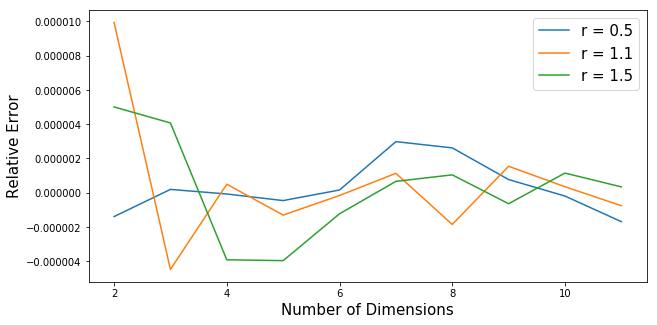

In [62]:
plt.figure(figsize=(10,5))
for i, r in enumerate(rs):
    plt.plot(ns, transform_at_r1[:, i]/ transform_at_r1_anl[:, i] - 1, label="r = %s"%r)

plt.legend(fontsize=15)
plt.xlabel("Number of Dimensions", fontsize=15)
plt.ylabel("Relative Error", fontsize=15);

Let's get the timing information for each calculation:

In [82]:
times = [0]*len(ns)
for i, n in enumerate(ns):
    times[i] = %timeit -o gn_hankel(rs, n);


9.86 ms ± 489 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.91 ms ± 145 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.2 ms ± 507 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
327 ms ± 6.09 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11 ms ± 90.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
324 ms ± 4.82 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.1 ms ± 104 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
329 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.3 ms ± 34 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
339 ms ± 8.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Here's a plot of the timing results. Note how odd-dimensions result in longer run-times, as the Bessel functions are 1/2-order, which requires more sophisticated methods from ``mpmath`` to calculate. There is no overall progression of the computational load with dimensionality, however.

This is in contrast to a FT approach, which scales as $N^n$, shown in green.

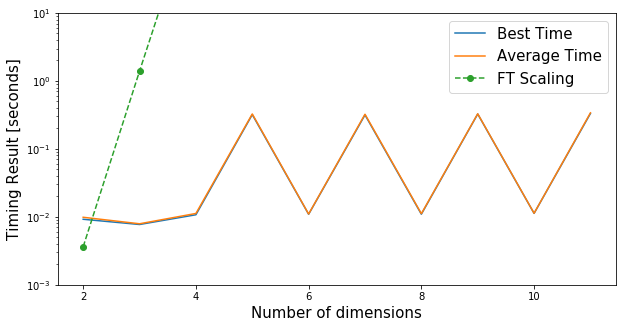

In [100]:
plt.figure(figsize=(10, 5))

plt.plot(ns, [t.best for t in times], label="Best Time")
plt.plot(ns, [t.average for t in times], label='Average Time')
plt.plot(ns[:6], 5e-9 * ns[:6] * (2*N)**ns[:6] * np.log(2*N), label="FT Scaling", ls ='--', marker='o')
plt.xlabel("Number of dimensions", fontsize=15)
plt.ylabel("Timing Result [seconds]", fontsize=15)
plt.ylim(1e-3, 10)
plt.yscale('log')
plt.legend(fontsize=15);

